### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

### Load dataset

In [2]:
tr_input, tr_target = bci.load("bci", train=True, one_khz=True)
te_input, te_target = bci.load("bci", train=False, one_khz=True)
tr_target = convert_to_one_hot_labels(tr_input, tr_target)
te_target = convert_to_one_hot_labels(te_input, te_target)

### Preprocessing

In [3]:
def lowpass_filtering(signal, N):    
    return np.convolve(signal, np.ones((N,))/N, mode='valid')

In [4]:
N = 10
sample = lowpass_filtering(tr_input[0,0,:].numpy(), N)

tr_input_filtered = torch.zeros([tr_input.shape[0],tr_input.shape[1],sample.shape[0]])
te_input_filtered = torch.zeros([te_input.shape[0],te_input.shape[1],sample.shape[0]])

for idx1, data in enumerate(tr_input):
    for idx2, channel in enumerate(data):
        tr_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10))

for idx1, data in enumerate(te_input):
    for idx2, channel in enumerate(data):
        te_input_filtered[idx1, idx2, :] = torch.from_numpy(lowpass_filtering(channel.numpy(), 10))

In [5]:
tr_input = tr_input_filtered
te_input = te_input_filtered

### record

In [25]:
# samples = tr_input[0,:,:].numpy()
# for sample in samples:
# #     sample = sample[0,:]
# #     sample = samples[0,0,:]
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample)
#     ax2.plot(abs(np.fft.fft(sample)))
#     plt.show()

#     N = 10
#     sample_filtered = np.convolve(sample, np.ones((N,))/N, mode='valid')

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
#     ax1.plot(sample_filtered)
#     ax2.plot(abs(np.fft.fft(sample_filtered)))
#     plt.show()

### Standardize

In [59]:
tr_input.shape

torch.Size([316, 28, 491])

In [6]:
num_channel = tr_input.shape[1]
signal_len = tr_input.shape[2]

tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

tr_input, tr_target = Variable(tr_input.view(-1,num_channel*signal_len)), Variable(tr_target)
te_input, te_target = Variable(te_input.view(-1,num_channel*signal_len)), Variable(te_target)

### PCA

In [7]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=5000)
pca.fit_transform(X=tr_input)
pca.fit_transform(X=te_input)

In [7]:
# for data in tr_input:
#     pca = PCA(n_components=2)

Variable containing:
 0.0293  0.0303  0.0311  ...   0.0522  0.0515  0.0515
 0.0974  0.0973  0.0977  ...  -0.0278 -0.0274 -0.0271
 0.0431  0.0422  0.0422  ...   0.0242  0.0228  0.0206
          ...             ⋱             ...          
 0.0632  0.0628  0.0619  ...   0.0120  0.0124  0.0128
 0.0511  0.0508  0.0515  ...   0.0276  0.0265  0.0250
 0.0533  0.0520  0.0512  ...   0.1614  0.1627  0.1633
[torch.FloatTensor of size 316x13748]

In [65]:
class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(size[1] * size[2], size[2])
        self.fc2 = nn.Linear(size[2], size[2])
        self.fc3 = nn.Linear(size[2], 2)
        
#         self.fc1 = nn.Linear(28 * 500, 500)
#         self.fc2 = nn.Linear(500, 500)
#         self.fc3 = nn.Linear(500, 2)
        
    def forward(self, x, mode=False):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x

In [67]:
# construct and train model
model = Net(tr_input_filtered.shape)
tr_loss, te_loss = bci.train_model(model, tr_input, tr_target, 4, te_input, te_target, 4, 50)
torch.save(model.state_dict(), os.getcwd() + "v1.pth")

# compute train and test errors
nb_tr_errors = bci.compute_nb_errors(model, tr_input, tr_target, 4)
nb_te_errors = bci.compute_nb_errors(model, te_input, te_target, 4)

print('tr error {:0.2f}% {:d}/{:d}'.format((100 * nb_tr_errors) / tr_input.size(0), nb_tr_errors, tr_input.size(0)))
print('te error {:0.2f}% {:d}/{:d}'.format((100 * nb_te_errors) / te_input.size(0), nb_te_errors, te_input.size(0)))

epoch 0 tr loss 79.35 te loss 25.04
epoch 1 tr loss 79.12 te loss 25.03
epoch 2 tr loss 78.92 te loss 25.03
epoch 3 tr loss 78.70 te loss 25.02
epoch 4 tr loss 78.44 te loss 25.04
epoch 5 tr loss 78.12 te loss 25.06
epoch 6 tr loss 77.73 te loss 25.11
epoch 7 tr loss 77.24 te loss 25.19
epoch 8 tr loss 76.68 te loss 25.32
epoch 9 tr loss 76.03 te loss 25.54
epoch 10 tr loss 75.33 te loss 25.89
epoch 11 tr loss 74.59 te loss 26.39
epoch 12 tr loss 73.84 te loss 26.98
epoch 13 tr loss 73.09 te loss 27.68
epoch 14 tr loss 72.32 te loss 28.42
epoch 15 tr loss 71.51 te loss 29.14
epoch 16 tr loss 70.64 te loss 29.84
epoch 17 tr loss 69.70 te loss 30.54
epoch 18 tr loss 68.69 te loss 31.30
epoch 19 tr loss 67.56 te loss 32.03
epoch 20 tr loss 66.35 te loss 32.75
epoch 21 tr loss 65.12 te loss 33.64
epoch 22 tr loss 63.76 te loss 34.77
epoch 23 tr loss 62.43 te loss 35.81
epoch 24 tr loss 60.92 te loss 36.83
epoch 25 tr loss 59.44 te loss 38.45
epoch 26 tr loss 57.98 te loss 39.98
epoch 27 tr

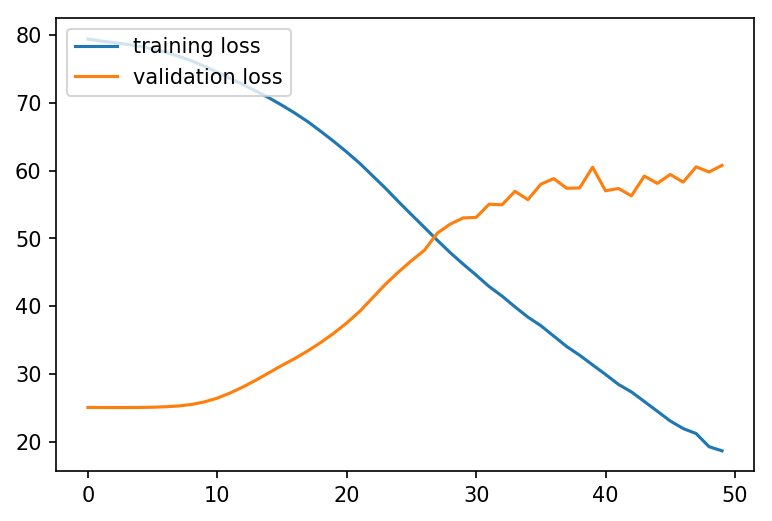

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')

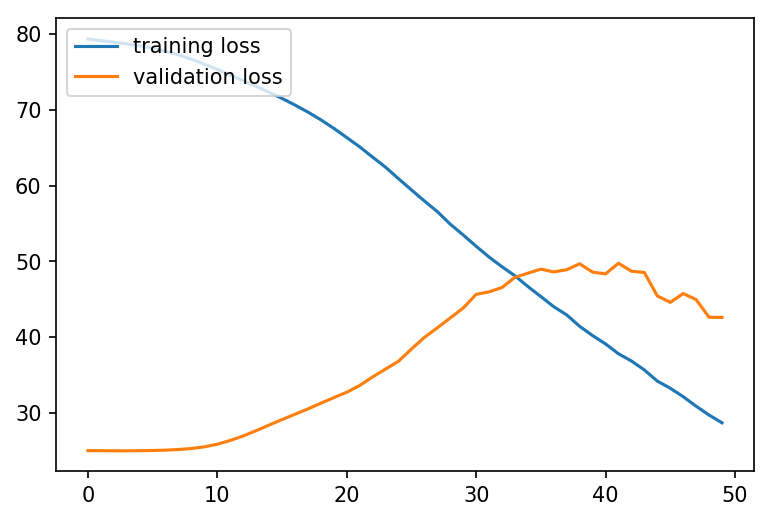

In [69]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')
plt.show()